In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy

In [205]:
class captcha(nn.Module):
    def __init__(self,layerN):
        super(captcha, self).__init__()
        self.feature = nn.Sequential(*self._make_feature_layers(layerN))
        self.classifier1 = nn.Sequential(*self._make_classifier_layers())
        self.classifier2 = nn.Sequential(*self._make_classifier_layers())
        self.classifier3 = nn.Sequential(*self._make_classifier_layers())
        self.classifier4 = nn.Sequential(*self._make_classifier_layers())
    
    def _make_feature_layers(self,layerN):
        layers = []
        for i in range(layerN):
            if i >=1:
                layers += [nn.Conv2d(32*2**(i-1), 32*2**i, kernel_size=3), 
                           nn.ReLU(inplace=True), 
                           nn.Conv2d(32*2**i, 32*2**i, kernel_size=3),
                           nn.ReLU(inplace=True),
                           nn.MaxPool2d(kernel_size=2)]
            else:
                layers += [nn.Conv2d(3, 32*2**i, kernel_size=3), 
                           nn.ReLU(inplace=True), 
                           nn.Conv2d(32*2**i, 32*2**i, kernel_size=3),
                           nn.ReLU(inplace=True),
                           nn.MaxPool2d(kernel_size=2)]
        return layers
                
    def _make_classifier_layers(self):
        layers = [nn.Linear(1536, 256),
                   nn.ReLU(),
                   nn.Linear(256, 128),
                   nn.ReLU(),
                   nn.Linear(128, 26)
                   #,nn.LogSoftmax(dim=1)
                 ]
        return layers
    
    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.shape[0], -1)
        x = F.dropout2d(x, p=0.25)
        return self.classifier1(x), self.classifier2(x), self.classifier3(x), self.classifier4(x)


In [206]:
model = captcha(4).double()
# oneImage = img
# oneImage = torch.tensor(oneImage.transpose(0,3,1,2)).type('torch.DoubleTensor') 
model(torch.from_numpy(g[0].transpose([0, 3, 1, 2])).type('torch.DoubleTensor'))[0].size()

torch.Size([128, 26])

In [96]:
try:
    import sklearn
    import cv2
    import captcha
    
except:
    !pip install scikit-learn
    !pip install opencv-python
    !apt update && apt install -y libsm6 libxext6  libxrender1 libxext-dev
    !pip install captcha
    import sklearn
    import cv2
    import captcha
    

import mxnet as mx
import sys
sys.path.append('/notebook/captcha_break/utils/')
from dataloader import *
%matplotlib inline

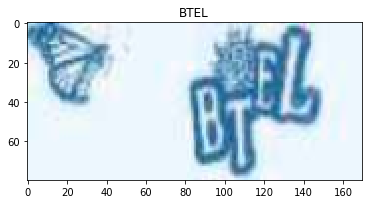

In [97]:
width, height, n_len, n_class = 170, 80, 4, 26+1
batch_size = 256

# characters = string.digits + string.ascii_uppercase
dataloader = DataLoader('../sample/')
def gen(batch_size= 128,trainMode = True):
    for  g in dataloader.generate(batchSize=batch_size ,trainMode=True):
        X   =  np.stack([cv2.resize(img,(width,height)) for img in g[0]])
        y =  np.array(g[1])
        yield [X, y]
    
import time
import pylab as pl
from IPython import display
for i in range(10):
    [X_test, y_test]  = next(gen(1))
    plt.imshow(X_test[0])
    plt.title(''.join([dataloader.remapDict[x] for x in y_test[0]]))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.5)
display.clear_output(wait=True)

In [98]:
# # def train(args, model, device, train_loader, optimizer, epoch):

#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = F.nll_loss(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % args.log_interval == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))

IndentationError: unexpected indent (<ipython-input-98-8fe9090fc4aa>, line 3)

In [171]:
g[1][:,0]

array([23, 13, 14,  0, 23,  0,  7, 23,  4, 23])

In [ ]:
batchsize = 128

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = captcha(4).double().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()


for epoch in range(1, 400):
    print('start epoch {}...'.format(epoch))
    if epoch % 5 == 0:
        torch.save(model.state_dict(), './torchModel/epoch_{}_model.pkl'.format(epoch))
    running_loss = 0.0
    model.train()
    
    batchNum = 0
    for g in gen(batchsize):
        data = torch.from_numpy(g[0].transpose([0, 3, 1, 2])).type('torch.DoubleTensor').to(device)
        target = torch.from_numpy(g[1]).type('torch.LongTensor').to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output[0], target[:,0]) + \
               criterion(output[1], target[:,1]) + \
               criterion(output[2], target[:,2]) + \
               criterion(output[3], target[:,3])
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.data[0]
        
        batchNum += 1
        if batchNum == len(dataloader.trainset_idx) // batch_size:
            print(running_loss / len(dataloader.trainset_idx) )
            break
            
        
 
        
        
        

start epoch 1...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(1.00000e-02 *
       4.8826, dtype=torch.float64, device='cuda:0')
start epoch 2...
tensor(1.00000e-02 *
       4.7552, dtype=torch.float64, device='cuda:0')
start epoch 3...
tensor(1.00000e-02 *
       3.2264, dtype=torch.float64, device='cuda:0')
start epoch 4...
tensor(1.00000e-02 *
       1.2811, dtype=torch.float64, device='cuda:0')
start epoch 5...
tensor(1.00000e-03 *
       8.0966, dtype=torch.float64, device='cuda:0')
start epoch 6...
tensor(1.00000e-03 *
       6.4734, dtype=torch.float64, device='cuda:0')
start epoch 7...
tensor(1.00000e-03 *
       5.3940, dtype=torch.float64, device='cuda:0')
start epoch 8...
tensor(1.00000e-03 *
       4.7290, dtype=torch.float64, device='cuda:0')
start epoch 9...
tensor(1.00000e-03 *
       4.2572, dtype=torch.float64, device='cuda:0')
start epoch 10...
tensor(1.00000e-03 *
       3.9070, dtype=torch.float64, device='cuda:0')
start epoch 11...
tensor(1.00000e-03 *
       3.5267, dtype=torch.float64, device='cuda:0')
start epoch 12

In [175]:
a = model(torch.from_numpy(g[0].transpose([0, 3, 1, 2])).type('torch.DoubleTensor'))[0]

x size is torch.Size([10, 256, 1, 6])
x size is torch.Size([10, 1536])
x size is torch.Size([10, 1536])


In [201]:
newModel = captcha(4)
newModel.load_state_dict(torch.load('./torchModel/epoch_1_model.pkl'))

In [210]:
batchNum

4